<a href="https://colab.research.google.com/github/mjimenalopez24/ProyectoIA_UNALFaces/blob/main/Api_Rec_Facial_Vivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color=red> <b> <i> RECONOCIMIENTO FACIAL


<center> <img src="https://fotografias-compromiso.atresmedia.com/clipping/cmsimages02/2020/06/09/BEDF67B1-7050-4704-863E-BA0E902FA45D/58.jpg"width='700' height='350'> </center>

## <font color= blue> Autores

*  [Danna Gabriela Bustacara Rodríguez](link), dbustacara@unal.edu.co
* [Kevin Andrés Leal Pérez](linkedin.com/in/kevin-andres-leal-perez-2a958a254), klealp@unal.edu.co
* [María Jimena López Munevar](link), malopezmu@unal.edu.co

## <font color= blue> Referencias


* [Tutorial: Reconocimiento Facial con Machine Learning en Python](https://www.codificandobits.com/blog/tutorial-reconocimiento-facial-python/)
* [Omes](https://omes-va.com/reconocimiento-facial-python-opencv/)


## <font color = blue> Introducción

Definir los modelos

In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow

In [ ]:
!pip install h5py

## <font color = blue> Datos

En este caso se seleccionan imagenes de referencia de 4 personas, que incluyen los 3 autores del proyecto y como factor adicional la hermana gemela de una de las autoras, para observar como se comporta el reconocimiento facial en estos casos. Las caracteristicas del conjunto de datos implementado para este cuaderno son:
- **Entrenamiento**: Cada uno de los 4 individuos, tiene asociadas 10 imagenes de entrenamiento.
- **Prueba**: Las imagenes de prueba serán en la captura de video en vivo.

In [ ]:
########## Librerías ################

# Tratamiento de imágenes
import cv2

# Reconocimiento Facial
import tensorflow as tf
print(tf.__version__)

 # Modelo FaceNet
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

# Básicas
import numpy as np
import matplotlib.pyplot as plt
import re # módulo de expresiones regulares

# Manejo de directorios
import os, sys

import math


2.12.0


## <font color =blue> Establecer directorios

A continuación se establecen los directorios donde en el primero encontraremos los rostros conocidos, es decir, los que estarán almacenados en la base de datos con anterioridad. En el segundo estarán los desconocidos, los cuales debe identificar y comparar con los conocidos y decidir si el rostro existe en la base de datos o no. Por último está el diccionario donde se guardarán los resultados de la detección.

In [ ]:
DIR_KNOWNS = 'C:/Users/kevin/Desktop/UNIVERSIDAD/9 semestre/Inteligencia Artificial/Proyecto Final/Datos/Aplicacion'
DIR_UNKNOWNS =  'C:/Users/kevin/Desktop/UNIVERSIDAD/9 semestre/Inteligencia Artificial/Proyecto Final/Img_Prueba/Unknown'
DIR_RESULTS = 'C:/Users/kevin/Desktop/UNIVERSIDAD/9 semestre/Inteligencia Artificial/Proyecto Final/Img_Prueba/Results'

La función load_image() servirá para cargar las imágenes en determinado directorio

In [ ]:
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{NAME}'), cv2.COLOR_BGR2RGB)

La función draw_box() servirá para dibujar una caja alrededor de la cara que se identifique en una imagen

In [ ]:
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

## <font color = blue > Detección de rostros con MobileNet

Para esta tarea haremos uso de MobileNet, una Red Convolucional especializada en la detección de objetos y optimizada para ejecución en dispositivos móviles, y que en este caso ha sido entrenada específicamente para la detección de rostros.

Este modelo pre-entrenado está almacenado en un formato de grafo de TensorFlow. Para realizar la lectura usaremos las funciones io.gfile y import_graph_def de TensorFlow, y el modelo será almacenado en la variable mobilenet:

In [ ]:
with tf.io.gfile.GFile('C:/Users/kevin/Desktop/UNIVERSIDAD/9 semestre/Inteligencia Artificial/Proyecto Final/Modelos/frozen_inference_graph_face.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

Sin embargo, el bloque de detección de rostros no nos devuelve el rostro en las mismas dimensiones que requiere Face Net, por esta razón la siguiente función se encargará de extrar la porción de la imágen que contiene el rostro y luego redimensionarla al tamaño [160x160].

In [ ]:
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

## <font color = blue> Función para la detección de rostros

Ahora implementaremos la función encargada de realizar la detección. Esta función tendrá como entradas la imagen original y un umbral (score_threshold). Este umbral se requiere pues MobileNet detecta múltiples regiones de interés para el mismo rostro, algunas de las cuales probablemente no corresponden a un rostro. Cada una de estas regiones de interés tendrá un puntaje entre 0 y 1 que nos indicará la probabilidad de que la región pertenezca o no a un rostro: 0 indica una baja probabilidad y 1 total certeza de que la región contiene un rostro.

Así que las regiones de interés y los puntajes correspondientes serán almacenados en las variables boxes y scores respectivamente, y tomaremos las regiones de interés con un umbral mayor o igual a 0.7 (es decir con un 70% de probabilidad de que contengan un rostro). Estas regiones seleccionadas serán almacenadas en la variable bboxes que contendrá las coordenadas dentro de la imagen de la esquina superior izquierda (left, top) y de la esquina inferior derecha (right, bottom) de cada region detectada:

In [ ]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    escala= imh*imw

    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')

    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})

    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)

    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]

    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])

    return bboxes, escala

## <font color=blue> Cálculo de embeddings usando Face Net

A continuación se carga el modelo el cual fue definido, creado y se le cargaron los pesos en el cuaderno ***Modelo FaceNet***.

In [ ]:
face_encoder = tf.keras.models.load_model('C:/Users/kevin/Desktop/UNIVERSIDAD/9 semestre/Inteligencia Artificial/Proyecto Final/Modelos/Face_Encoder.h5')

Al imprimir en pantalla las variables input_shape y output_shape del modelo, podemos verificar que el tamaño de la entrada es una imagen RGB de 160x160 pixeles, mientras que a la salida se generará un embedding correspondiente a un vector de 128 elementos:

In [ ]:
print(face_encoder.input_shape)
print(face_encoder.output_shape)

(None, 160, 160, 3)
(None, 128)


La siguiente función tiene como entrada el modelo que se implementará para obtener el embedding de un rostro, y la imágen a la cual se le quiere obtener este vector. La salida será el embedding

In [ ]:
def compute_embedding(model,face):
    face = face.astype('float32')

    mean, std = face.mean(), face.std()
    face = (face-mean) / std

    face = np.expand_dims(face,axis=0)

    embedding = model.predict(face)
    return embedding

## <font color = blue> Reconocimiento Facial: Comparando los embedding

Lo primero que se debe hacer es calcular el embedding de todos los rostros de referencia, es decir, los que guardaremos con anterioridad en la base de datos. Estos vectores se almacenarán en la lista known_embeddings, siempre y cuando haya una detección de rostros en las imagenes.

In [ ]:
known_faces = dict()
cont = 0
print('Procesando rostros conocidos...')
for label in os.listdir(DIR_KNOWNS):
    # Se crea una lista que será el valor de cada carpeta en el diccionario
    known_embeddings = []
    image_path = os.path.join(DIR_KNOWNS, label)
    cont = cont+1
    print('Procesando carpeta número '+str(cont)+'. Nombre:' + label)
    for image_name in os.listdir(os.path.join(DIR_KNOWNS, label)):
        image = load_image(image_path,image_name)
        bboxes,_ = detect_faces(image)
        # condicional para que se guarde solo si puedo identificar la imagen
        if bboxes != []:
            face = extract_faces(image,bboxes)
            known_embeddings.append(compute_embedding(face_encoder,face[0]))
    known_faces[label] = known_embeddings

Procesando rostros conocidos...
Procesando carpeta número 1. Nombre:Danna Bustacara
1/1 [==============================] - 0s 82ms/step
Procesando carpeta número 2. Nombre:Jimena_Lopez
1/1 [==============================] - 0s 86ms/step
Procesando carpeta número 3. Nombre:Kevin Leal
1/1 [==============================] - 0s 74ms/step
Procesando carpeta número 4. Nombre:Mariana Bustacara
1/1 [==============================] - 0s 71ms/step


In [ ]:
keys_dict = known_faces.keys()
keys_dict

dict_keys(['Danna Bustacara', 'Jimena_Lopez', 'Kevin Leal', 'Mariana Bustacara'])

In [ ]:
known_faces["Kevin Leal"][0]

array([[ 1.55368745e-02,  7.14437246e-01,  2.76313961e-01,
         1.54643452e+00,  5.03853709e-02,  1.21580720e+00,
         1.00107324e+00, -5.28888941e-01,  5.74866295e-01,
         1.30570614e+00, -6.18598580e-01,  1.14477873e+00,
        -2.46256948e-01, -1.94499731e+00,  9.31228518e-01,
        -1.14001453e+00,  2.35996485e+00, -7.08520189e-02,
         3.42030883e-01, -6.80854738e-01,  3.96195084e-01,
        -2.27576828e+00,  2.54357576e-01, -2.46352017e-01,
        -7.35051394e-01, -1.32660389e+00,  7.21970081e-01,
         7.14745939e-01, -1.03408849e+00, -1.74459791e+00,
        -7.45722175e-01, -5.94352007e-01, -3.18755388e-01,
        -8.09989631e-01,  1.09719181e+00, -1.43508017e+00,
        -2.01535344e+00, -3.23272347e-01, -2.98361272e-01,
        -9.95979667e-01, -1.44649816e+00, -5.20296752e-01,
        -1.69655049e+00,  2.79883057e-01,  5.96140087e-01,
         5.59010983e-01, -8.33622098e-01,  7.49312878e-01,
         7.88814664e-01, -1.11783755e+00,  1.33059728e+0

La función que se está definiendo, será la encargada de realizar la verificación del nuevo rostro, o rostro de prueba. Para el enfoque que se implementa con el conjunto de datos considerado, tiene como entradas dos diccionarios, el primero de los diccionarios es el resultante al calcular los embedding de referencia, así que tendra asociados algunos vectores por individuo, con un máximo de 10, si la red MobileNet fue capaz de detectar rostros en todas las imagenes, y 0 como minimo, si de la totalidad de imagenes asociadas a un rostro no hubo ninguna detección con MobileNet. Por otro lado, el segundo diccionario, tiene como claves los individuos y los embeddings de las imagenes de prueba, que se van a calcular en vivo, con el apoyo del reconocimiento facial en vivo. Y en el caso de no estar capturando en vivo, el segundo diccionario, tiene asociados los embeddings que se calculan para las imagenes de referencia

La comparación será simplemente la distancia entre vectores y se les aplicara un umbral, que se fija como 11. A la salida de la función se retornará un valor indicando la menor de las distancias, siempre y cuando sea menor que el umbral. Lo último, para que en vivo se imprima la etiqueta asociada a la menor distancia de un rostro de prueba a uno de referencia, siempre y cuando sea menor que el umbral. Si ninguna distancia es menor al umbral, ese rostro será detectado como desconocido.

In [ ]:
def which(lst, value):
    indices = [i for i, x in enumerate(lst) if x == value]
    return indices if indices else None

In [ ]:
def compare_faces(embs_ref, emb_desc, umbral=10):
    Claves = embs_ref.keys()
    reconocimiento = []
    minimo = []
    for clave in Claves:
        persona = embs_ref[clave]
        distancias = []
        for i in persona:
            distancias.append(np.linalg.norm(i-emb_desc))

        distancias = np.array(distancias)
        if any(distancias<=umbral):
            reconocimiento.append(True)
            minimo.append(min(distancias))
        else:
            reconocimiento.append(False)
            minimo.append(min(distancias))

    Per_oficial = which(reconocimiento, True)
    verdadero = which(minimo,min(minimo))

    if Per_oficial == None:
        Persona = False
    else:
        Persona = list(Claves)[verdadero[0]]

    return minimo, Persona

Lo único que resta ahora es aplicar esta función a cada una de las imágenes de prueba. Para determinar si la imagen de prueba contiene o no el rostro de referencia será suficiente con que al menos una de las cuatro distancias calculadas (realizadas por compare_faces) sea inferior al umbral establecido anteriormente:

In [ ]:
def draw_text(image,text,box,line_width,color,grueso):
    if box==[]:
        return image
    else:
        cv2.putText(image,text,(box[0],box[2]-15),cv2.FONT_ITALIC,line_width,color,grueso)
    return image

Para la prueba del reconocimiento facial con fotos se cargan varias imágenes, y como resultado se tendrá la etiqueta con el nombre de la persona, o si son varios rostros los que se detectan, con el nombre de las personas que se identificaron en la imagen.

In [ ]:
print('Procesando imágenes desconocidas...')
for name in os.listdir(DIR_UNKNOWNS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_UNKNOWNS,name)
        bboxes, escala = detect_faces(image)
        faces = extract_faces(image,bboxes)
        escala = np.sqrt(escala)
        # Por cada rostro calcular embedding
        img_with_boxes = image.copy()
        for face, box in zip(faces,bboxes):
            emb = compute_embedding(face_encoder,face)
            minimos, reconocimiento = compare_faces(known_faces,emb)
            print(minimos)
            if reconocimiento == False:
                print('     Esta cara no existe en el registro')
                img_with_boxes = draw_box(img_with_boxes,box,(255,0,0),int(escala*0.005))
                img_with_boxes = draw_text(img_with_boxes,"Desconocido",box,int(escala*0.005)/4,(255,0,0),int(escala*0.005))
            else:
                print(reconocimiento)
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0),int(escala*0.005))
                img_with_boxes = draw_text(img_with_boxes,str(reconocimiento),box,int(escala*0.005)/4,(0,255,0),int(escala*0.005))

        cv2.imwrite(f'{DIR_RESULTS}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
print('¡Fin!')

Procesando imágenes desconocidas...
   Danna.jpg
1/1 [==============================] - 0s 77ms/step
[5.3604755, 9.750705, 13.025233, 7.6224113]
Danna Bustacara
   Dos.jpg
1/1 [==============================] - 0s 107ms/step
[6.631447, 10.081444, 13.462168, 7.1334004]
Danna Bustacara
1/1 [==============================] - 0s 108ms/step
[6.468148, 10.600881, 13.0623665, 9.506008]
Danna Bustacara
   Dos_2.jpg
1/1 [==============================] - 0s 100ms/step
[10.153784, 12.676916, 13.622238, 9.420269]
Mariana Bustacara
1/1 [==============================] - 0s 109ms/step
[10.429667, 12.040406, 13.985813, 6.5113363]
Mariana Bustacara
   jimena_001.jpg
1/1 [==============================] - 0s 70ms/step
[10.309046, 0.0, 14.171431, 11.207696]
Jimena_Lopez
   Kevin_006.jpg
1/1 [==============================] - 0s 81ms/step
[11.885994, 14.842046, 8.933967, 12.555561]
Kevin Leal
   Kevin_007.jpg
1/1 [==============================] - 0s 63ms/step
[12.466063, 12.667821, 0.0, 12.648934]
Kevi

El resultado para las imágenes donde solo aparece un rostro es congruente con la persona que se encuentra en la imagen. Por otro lado, las imágenes donde aparecen rostros dificiles de clasificar, en este caso por su similitud, el resultado para uno de los dos no es correcto, como se muestra a continuación:

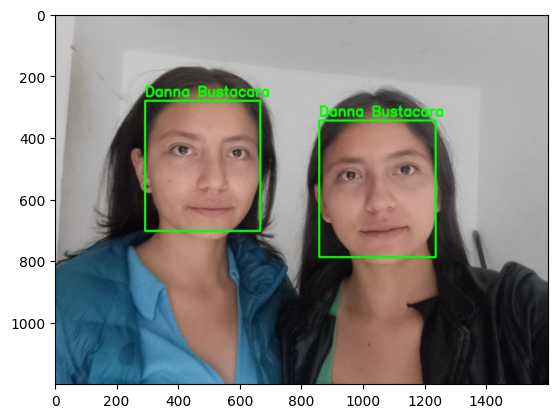

In [ ]:
image = load_image('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Img_Prueba/Results','Dos.jpg')
plt.imshow(image)
image1 = load_image('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Img_Prueba/Results','Dos_2.jpg')
image2 = load_image('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Img_Prueba/Results','Danna.jpg')
image3 = load_image('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Img_Prueba/Results','Mariana.jpg')

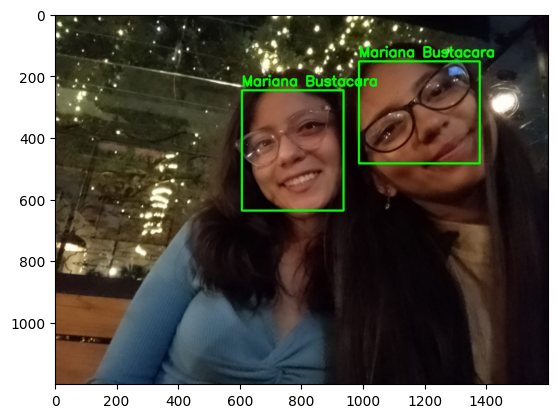

In [ ]:
plt.imshow(image1)

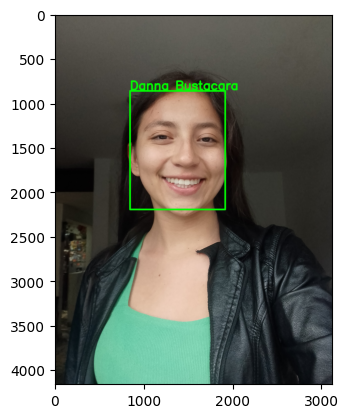

In [ ]:
plt.imshow(image2)

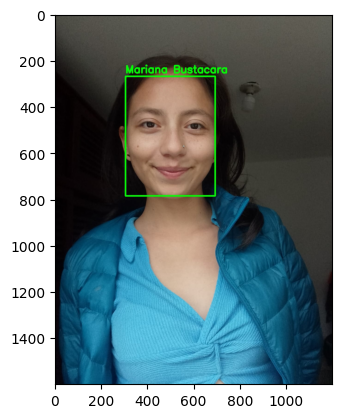

In [ ]:
plt.imshow(image3)

La siguiente función nos permite realizar reconocimiento facial en vivo, que se ejecuta recibiendo cada uno de los frames que se obtienen de los videos que se graban desde la cámara del computador.
Es importante resaltar que para el correcto funcionamiento del reconocimiento facial en vivo, es necesario que se ejecute desde un programa desde el computador.

In [ ]:
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)

while True:
    ret,frame = cap.read()
    if ret == False: break
    img_with_boxes = frame.copy()
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #faces = faceClassif.detectMultiScale(image,1.3,5)

    bboxes,_ = detect_faces(image)
    faces = extract_faces(image,bboxes)

    for face, box in zip(faces,bboxes):
            emb = compute_embedding(face_encoder,face)
            minimos, reconocimiento = compare_faces(known_faces,emb)

            if reconocimiento == False:
                img_with_boxes = draw_box(img_with_boxes,box,(0,0,255),6)
                img_with_boxes = draw_text(img_with_boxes,"Desconocido",box,1,(0,0,255),2)
            else:
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0),6)
                img_with_boxes = draw_text(img_with_boxes,str(reconocimiento),box,1,(0,255,0),2)

    cv2.imshow('frame',img_with_boxes)
    k = cv2.waitKey(1)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 68ms/step
